## Perform spatial trajectory inference

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import preprocessing
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

import warnings
warnings.filterwarnings("ignore")

### Load results

In [2]:
res_dir = "Results/INSPIRE_DLPFC"
adata = sc.read_h5ad(res_dir + "/adata_inspire.h5ad")
basis_df = pd.read_csv(res_dir + "/basis_df_inspire.csv", index_col=0)
basis = np.array(basis_df.values)

In [3]:
slice_colors = ["#3A4CC0", "#AAC6FD", "#F6B79C", "#B40126"]
layer_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2"]
layer = ["L1", "L2", "L3", "L4", "L5", "L6", "WM"]

umap = adata.obsm["X_umap"]
meta = adata.obs[["slice_id", "layer", "GM"]]
meta["slice"] = meta["slice_id"].values.astype(str)
meta["slice"][meta["slice"] == "151673.0"] = 0
meta["slice"][meta["slice"] == "151674.0"] = 1
meta["slice"][meta["slice"] == "151675.0"] = 2
meta["slice"][meta["slice"] == "151676.0"] = 3
meta["slice_color"] = [slice_colors[int(meta["slice"][i])] for i in range(meta.shape[0])]
meta["layer_color"] = meta["layer"].values.astype(str)
for i in range(len(layer)):
    meta["layer_color"][meta["layer"].values.astype(str) == layer[i]] = layer_colors[i]
order = [6,3,5,1,0,4,2]
meta["Cluster"] = [order[label] for label in meta["GM"].values]
umap_ours = umap.copy()
meta_ours = meta.copy()

### Spatial trajectory inference

In [4]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.paga(adata, groups='layer')
pos = []
for layer_tmp in ["L1", "L2", "L3", "L4", "L5", "L6", "WM"]:
    center = np.mean(umap[adata.obs['layer'].values.astype(str)==layer_tmp, :], axis=0)
    pos.append(center)

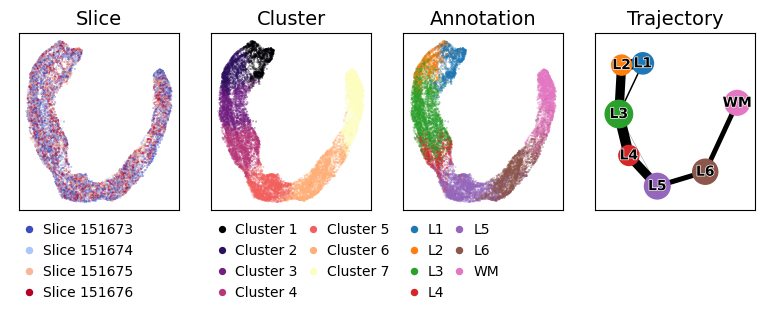

In [5]:
f = plt.figure(figsize=(9.5,2.3))
n_cells = umap_ours.shape[0]
size = 0.03
np.random.seed(1234)
order = np.arange(n_cells)
np.random.shuffle(order)

ax1 = f.add_subplot(1,4,1)
scatter1 = ax1.scatter(umap[order, 0], umap[order, 1], s=size, c=meta["slice_color"][order], rasterized=True)
ax1.set_title("Slice", fontsize=14)
ax1.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
legend_elements_slice = [Line2D([0], [0], marker='o', color="w", label='Slice 151673', markerfacecolor=slice_colors[0], markersize=8),
                         Line2D([0], [0], marker='o', color="w", label='Slice 151674', markerfacecolor=slice_colors[1], markersize=8),
                         Line2D([0], [0], marker='o', color="w", label='Slice 151675', markerfacecolor=slice_colors[2], markersize=8),
                         Line2D([0], [0], marker='o', color="w", label='Slice 151676', markerfacecolor=slice_colors[3], markersize=8)]
ax1.legend(handles=legend_elements_slice, loc="upper left", bbox_to_anchor=(-0.1, 0.), frameon=False, 
           markerscale=.8, fontsize=10, handletextpad=0.)

ax2 = f.add_subplot(1,4,2)
scatter2 = ax2.scatter(umap[:, 0], umap[:, 1], s=size, rasterized=True, c=meta["Cluster"].values, cmap='magma')
ax2.set_title("Cluster", fontsize=14)
ax2.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
l2 = ax2.legend(handles=scatter2.legend_elements()[0], 
                labels=["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5", "Cluster 6", "Cluster 7"], 
                loc="upper left", bbox_to_anchor=(-0.1, 0.), 
                markerscale=.7, title_fontsize=10, fontsize=10, frameon=False, ncol=2, handletextpad=0., columnspacing=0.1)
l2._legend_box.align = "left"

ax3 = f.add_subplot(1,4,3)
scatter3 = ax3.scatter(umap[order, 0], umap[order, 1], s=size, c=meta["layer_color"][order], rasterized=True)
ax3.set_title("Annotation", fontsize=14)
ax3.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
legend_elements_layer = [Line2D([0], [0], marker='o', color="w", label=layer[0], markerfacecolor=layer_colors[0], markersize=8),
                         Line2D([0], [0], marker='o', color="w", label=layer[1], markerfacecolor=layer_colors[1], markersize=8),
                         Line2D([0], [0], marker='o', color="w", label=layer[2], markerfacecolor=layer_colors[2], markersize=8),
                         Line2D([0], [0], marker='o', color="w", label=layer[3], markerfacecolor=layer_colors[3], markersize=8),
                         Line2D([0], [0], marker='o', color="w", label=layer[4], markerfacecolor=layer_colors[4], markersize=8),
                         Line2D([0], [0], marker='o', color="w", label=layer[5], markerfacecolor=layer_colors[5], markersize=8),
                         Line2D([0], [0], marker='o', color="w", label=layer[6], markerfacecolor=layer_colors[6], markersize=8)]
ax3.legend(handles=legend_elements_layer, loc="upper left", bbox_to_anchor=(-0.1, 0.), frameon=False, 
           markerscale=.8, fontsize=10, handletextpad=0., ncol=2, columnspacing=0.1)

ax4 = f.add_subplot(1,4,4)
ax4.set_title("Trajectory", fontsize=14)
ax4.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax4.set_xlim(ax3.get_xlim())
ax4.set_ylim(ax3.get_ylim())
sc.pl.paga(adata, pos=np.array(pos), node_size_scale=2, edge_width_scale=1, fontsize=10, fontoutline=1, ax=ax4)

f.subplots_adjust(hspace=0.02, wspace=0.02)
plt.show()